In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os, sys
sys.path.append('..')

In [2]:
path = '../../../KU/Bachelor+Research/Data/Axetris/Own setup/'

In [3]:
def read_data(path):
    files = os.listdir(path)
    data_dict = {}

    for file in files:
        if 'Leak_test' in file:
            name = file.split('.')[0]
            with open(os.path.join(path, file)) as f:
                df = pd.read_csv(f, sep = '\t')
                # df['Seconds'] = df['Seconds'] - df['Seconds'][0]
                # df = df.dropna()

            data_dict[name] = df
    return data_dict

In [4]:
leak_test = read_data(path)

display(leak_test)

{'Leak_test1_05032024':           Seconds    CH4 [ppm]
 0     4324.415934     0.000000
 1     4324.891036    -0.280000
 2     4325.382496    -0.200000
 3     4325.886007     0.000000
 4     4326.358267    -0.030000
 ...           ...          ...
 7930  8200.940476  9293.589844
 7931  8201.411284  9194.519531
 7932  8201.912259  9110.649414
 7933  8202.385701  9009.490234
 7934  8202.878257  8932.040039
 
 [7935 rows x 2 columns],
 'Leak_test2_05032024':           Seconds    CH4 [ppm]
 0        9.604650  4339.679688
 1       10.099681  3959.339844
 2       10.590488  3924.020020
 3       11.063991  3878.289795
 4       11.554741  3847.409912
 ...           ...          ...
 3202  1574.788744  2005.359985
 3203  1575.275112  2006.069946
 3204  1575.759893  2000.359985
 3205  1576.260608  2005.179932
 3206  1576.729443  2002.919922
 
 [3207 rows x 2 columns]}

In [5]:
def overview_plot_leak(ax, df):
    ax.plot(df['Seconds'], df['CH4 [ppm]'], lw = 1)
    
    ax.set(xlabel = 'Time / s', ylabel = 'CH4 concentration / ppm')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.yaxis.offsetText.set_fontsize(9)

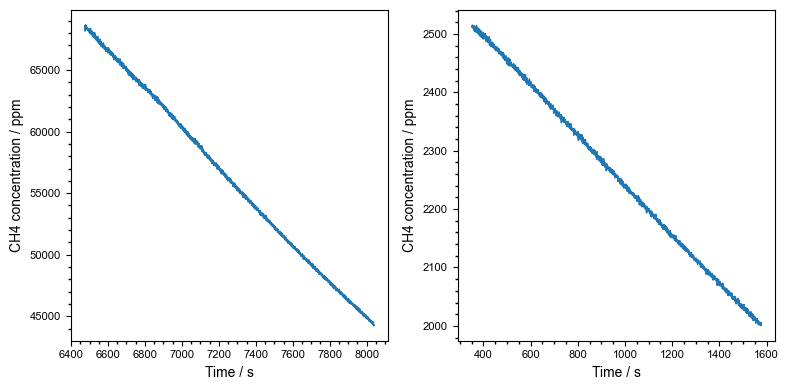

In [7]:
fig, ax = plt.subplots(1,2, figsize = (8, 4))

overview_plot_leak(ax[0], leak_test['Leak_test1_05032024'][4400:7600])
overview_plot_leak(ax[1], leak_test['Leak_test2_05032024'][700:-1])

fig.tight_layout()
fig.savefig('leak_test.png', dpi = 600)
plt.show()

In [21]:
def dict_for_treatment(data_dict, idx_array):
    new_dict = {}
    for i, key in enumerate(data_dict.keys()):
        df = data_dict[key][idx_array[i][0]:idx_array[i][1]]
        df.reset_index(drop=True, inplace=True)
        df['Seconds'] = df['Seconds'] - df['Seconds'][0]
        new_dict[key] = df
    return new_dict

In [23]:
idx_leak = np.array([[4400, 7600], [700, -1]])

leak_treat = dict_for_treatment(leak_test, idx_leak)
display(leak_treat)

C:\Users\nan25\AppData\Local\Temp\ipykernel_15540\1340427269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seconds'] = df['Seconds'] - df['Seconds'][0]


{'Leak_test1_05032024':           Seconds     CH4 [ppm]
 0        0.000000  68537.296875
 1        0.484932  68169.828125
 2        0.984518  68624.796875
 3        1.468809  68335.117188
 4        1.953543  68596.578125
 ...           ...           ...
 3195  1561.740378  44237.230469
 3196  1562.240524  44306.890625
 3197  1562.725145  44279.617188
 3198  1563.210705  44306.417969
 3199  1563.695944  44280.078125
 
 [3200 rows x 2 columns],
 'Leak_test2_05032024':           Seconds    CH4 [ppm]
 0        0.000000  2511.510010
 1        0.485897  2514.169922
 2        0.973633  2512.589844
 3        1.475793  2511.060059
 4        1.946268  2515.169922
 ...           ...          ...
 2501  1222.498560  2003.059937
 2502  1222.999377  2005.359985
 2503  1223.485745  2006.069946
 2504  1223.970526  2000.359985
 2505  1224.471241  2005.179932
 
 [2506 rows x 2 columns]}